# Test Models

This notebook tests deep learning models for enhanced JPEG reconstruction.

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.backend import eval as tf_eval
import skimage.measure as metrics

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from cs_models import deep_cascade_unet_no_dc
from metrics import calculate_metrics

Using TensorFlow backend.


In [2]:
# Train and validation data paths
test_path = "/home/ubuntu/volume1/TIFF/Testing/*.tif"

# Listing train and validation images
test_images = glob.glob(test_path)

# Summary of images
print("Test set size:", len(test_images))

Test set size: 16110


In [11]:
H,W = 256, 256
norm = 255.0
compr_range = (10,20)

test_unc = np.zeros((len(test_images),H,W,1), dtype=np.float32)
test_compr = test_unc.copy()

compr_test = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(test_images),replace = True)

# Test set
for ii in range(len(test_images)):
    # Load uncompressed image
    im1 = Image.open(test_images[ii])
    test_unc[ii,:,:,0] = np.array(im1, np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_test[ii]))
    im2 = Image.open(buf)
    test_compr[ii,:,:,0] = np.array(im2, np.float32)

test_unc -= 128.0
test_compr -= 128.0

test_unc /= 128.0
test_compr /= 128.0

In [12]:
opt=Adam(lr=0.0001)
model_name = "../Models/residual_wnet_ii_data_augmentation_compress_10_20.hdf5"
model=deep_cascade_unet_no_dc(depth_str='ii')
model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)

0 i
Append U-net block
1 i
Append U-net block


In [13]:
pred = model.predict(test_compr)

-1.0 0.3203125
-1.019729 0.28245565


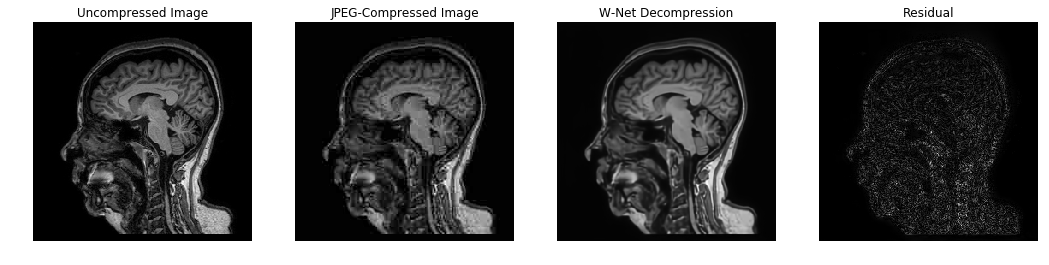

In [14]:
#print(pred)

slc = 65

print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(pred[slc,:,:,0]),np.max(pred[slc,:,:,0]))

plt.figure(figsize = (18,12))
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("W-Net Decompression")
plt.imshow(pred[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - pred[slc,:,:,0]),cmap = "gray")
plt.show()

Test set results


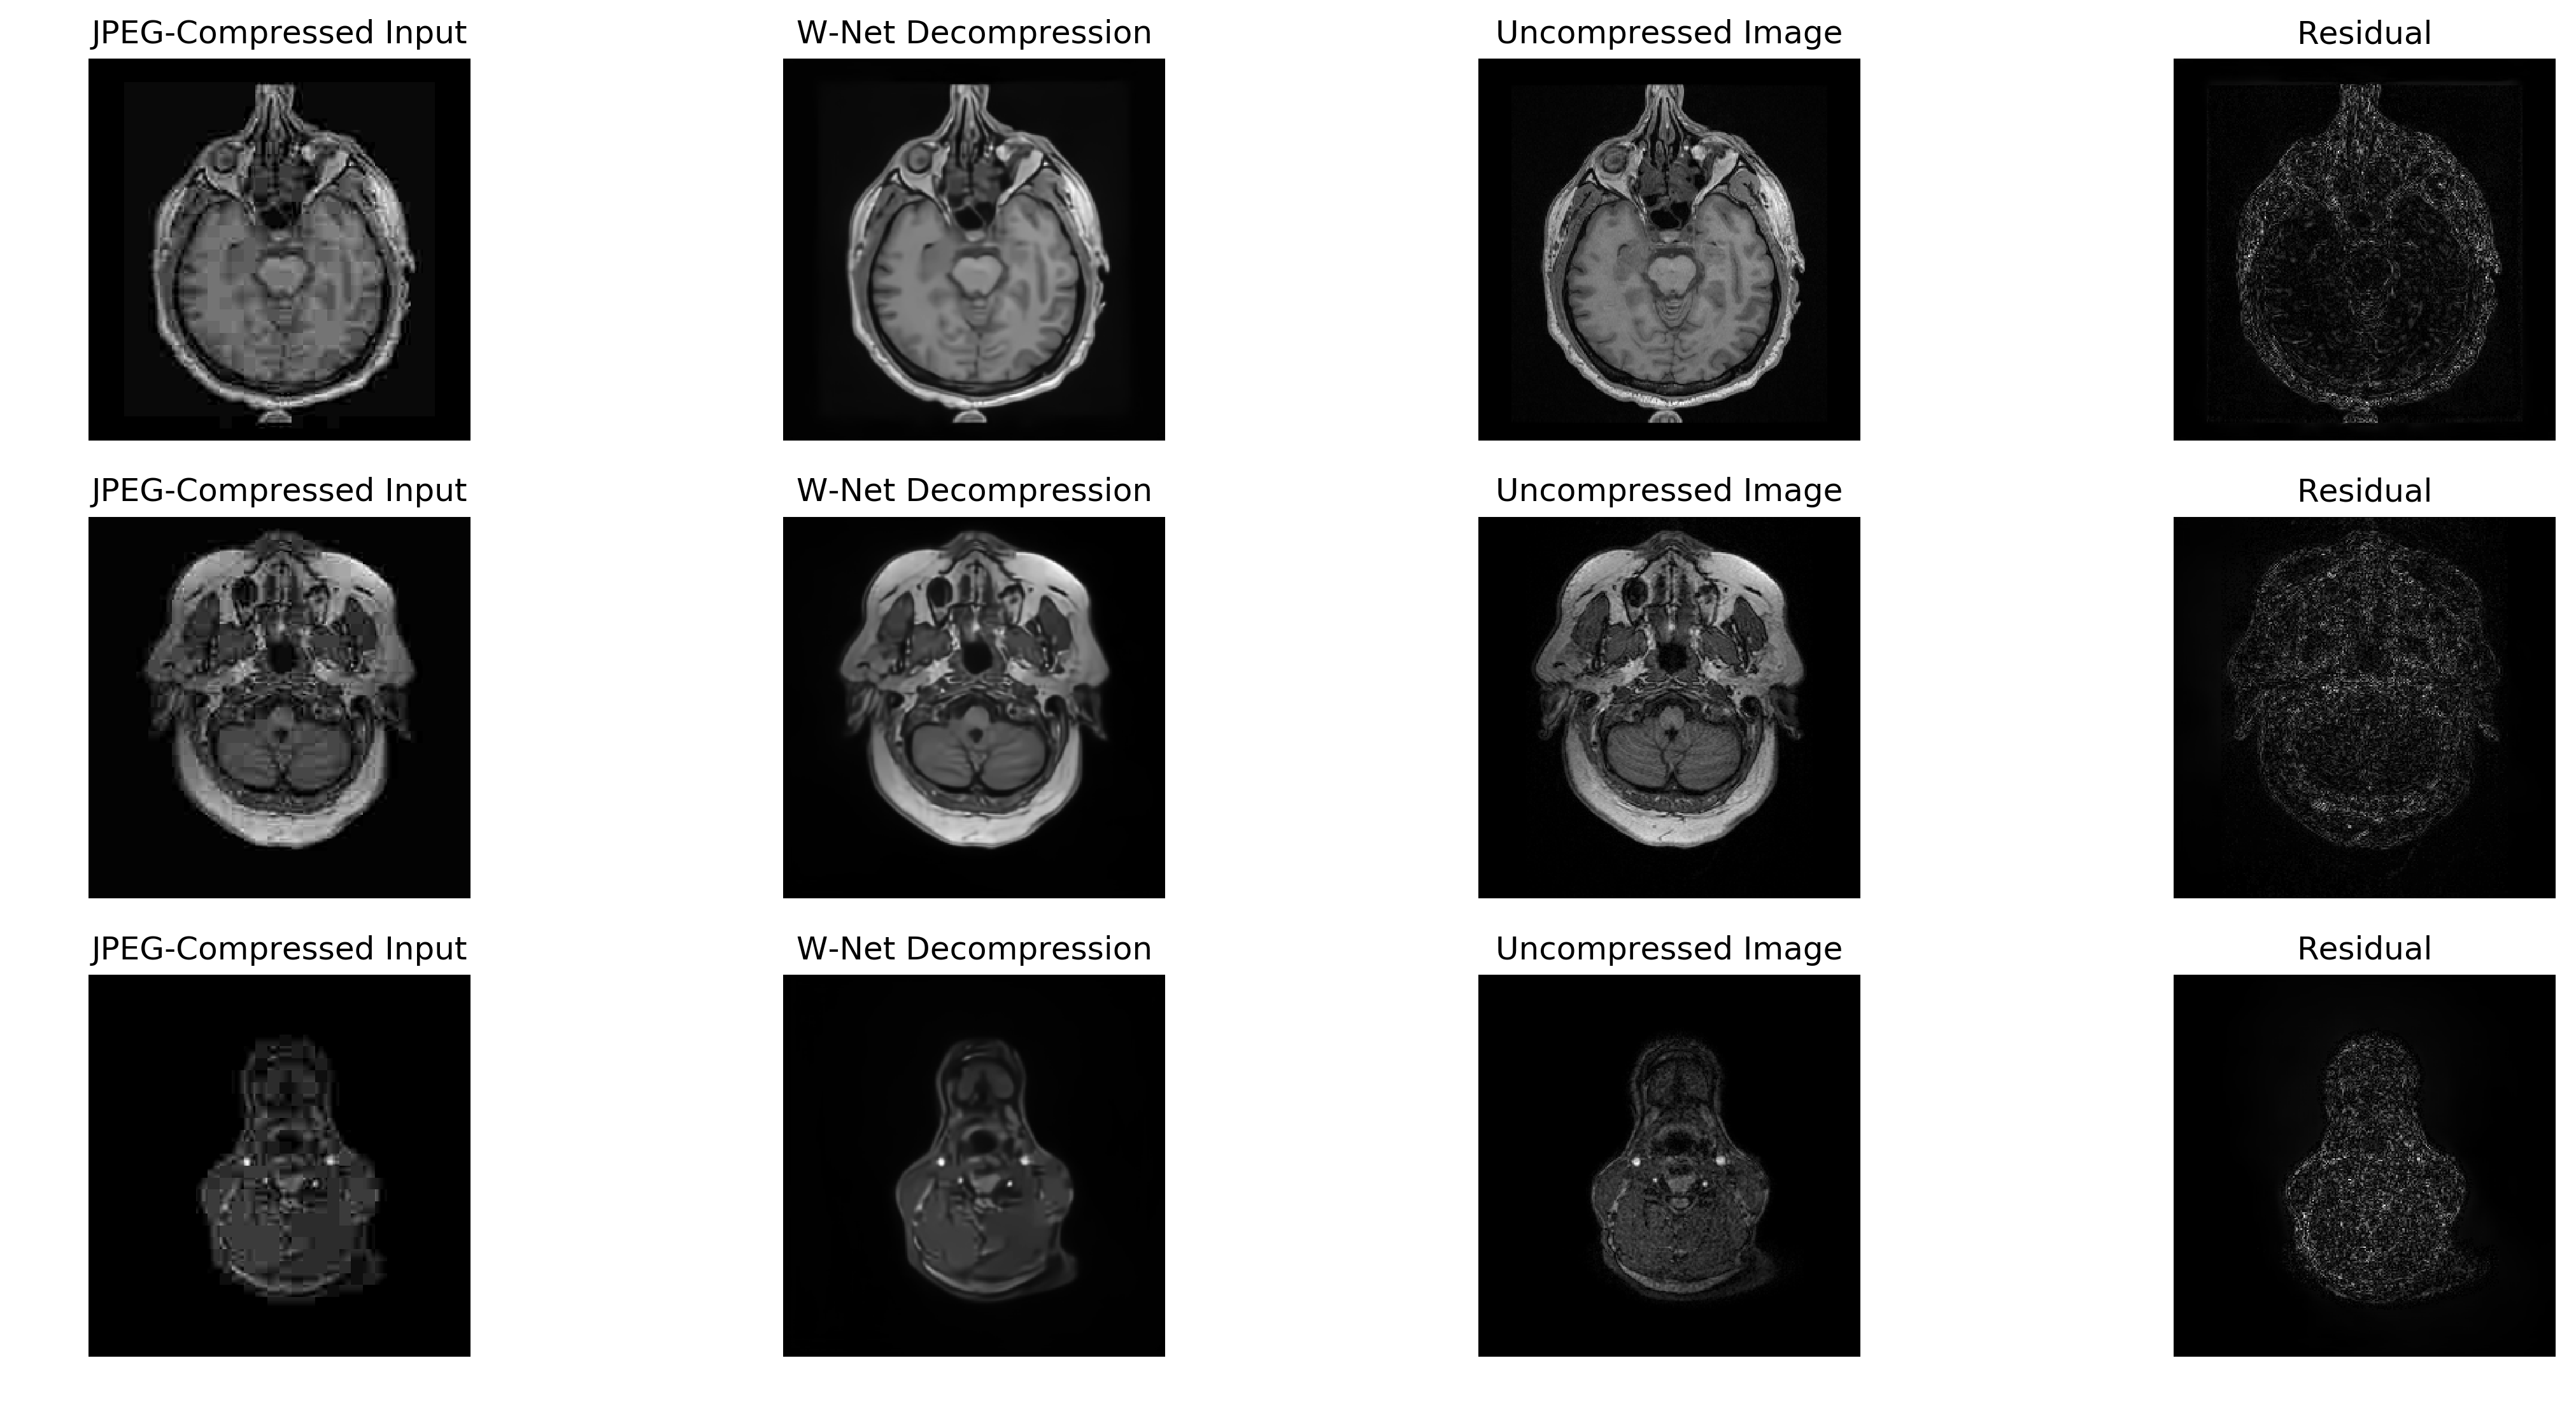

In [15]:
indexes_test = np.arange(len(test_images),dtype = int)
np.random.shuffle(indexes_test)
indexes_test = indexes_test[:3]

print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Input")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(pred[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("W-Net Decompression")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Image")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(abs(test_unc[indexes_test[ii],:,:,0]-pred[indexes_test[ii],:,:,0]),cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

In [ ]:
metr = calculate_metrics(test_unc, test_compr, pred)

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:206: RuntimeWarning: invalid value encountered in true_divide
  S = (A1 * A2) / D


removing 1629 SSIM from JPEG list.
removing 1715 SSIM from JPEG list.
removing 1890 SSIM from JPEG list.
removing 1896 SSIM from JPEG list.
removing 3240 SSIM from JPEG list.


In [ ]:
metr = np.zeros((len(pred),3,2),dtype=np.float32)

for ii in range(len(pred)):
    # JPEG-Compressed Metrics
    metr[ii,0,0] = metrics.compare_ssim(test_unc[ii,:,:,0],test_compr[ii,:,:,0])
    metr[ii,1,0] = metrics.compare_psnr(test_unc[ii,:,:,0],test_compr[ii,:,:,0],\
                                        data_range=(test_compr[ii,:,:,0].max()-test_compr[ii,:,:,0].min()))
    metr[ii,2,0] = metrics.compare_nrmse(test_unc[ii,:,:,0],test_compr[ii,:,:,0],'min-max') *100.0
    
    # Network Metrics
    metr[ii,0,1] = metrics.compare_ssim(test_unc[ii,:,:,0],pred[ii,:,:,0])
    metr[ii,1,1] = metrics.compare_psnr(test_unc[ii,:,:,0],pred[ii,:,:,0],\
                                       data_range=(pred[ii,:,:,0].max()-pred[ii,:,:,0].min()))
    metr[ii,2,1] = metrics.compare_nrmse(test_unc[ii,:,:,0],pred[ii,:,:,0],'min-max') *100.0

print("JPEG-Compressed Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,0].mean(),metr[:,0,0].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,0].mean(),metr[:,1,0].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,0].mean(),metr[:,2,0].std()))
print('\n')
print("Network Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,1].mean(),metr[:,0,1].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,1].mean(),metr[:,1,1].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,1].mean(),metr[:,2,1].std()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:142: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range ** 2) / err)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom


In [ ]:
tester=metr.copy()

In [ ]:
for ii in range(len(tester)):
    for jj in range(3):
        for kk in range(2):
            if ~np.isfinite(tester[ii,jj,kk]):
                tester= np.delete(tester,ii,0)
                ii+=1

In [ ]:
print("JPEG-Compressed Metrics")
print("SSIM: %.3f +/- %.3f" %(tester[:,0,0].mean(),tester[:,0,0].std()))
print("PSNR: %.3f +/- %.3f" %(tester[:,1,0].mean(),tester[:,1,0].std()))
print("NRMSE: %.3f +/- %.3f" %(tester[:,2,0].mean(),tester[:,2,0].std()))
print('\n')
print("Network Metrics")
print("SSIM: %.3f +/- %.3f" %(tester[:,0,1].mean(),tester[:,0,1].std()))
print("PSNR: %.3f +/- %.3f" %(tester[:,1,1].mean(),tester[:,1,1].std()))
print("NRMSE: %.3f +/- %.3f" %(tester[:,2,1].mean(),tester[:,2,1].std()))